# Questão 3: Projeto de Controlador PID

## Especificações do Problema

Projetar um controlador PID para o sistema:
- **Sistema:** G(s) = K/[(s+1)(s+4)]
- **Objetivos:**
  - Tempo de pico: tp = 1.047 s
  - Coeficiente de amortecimento: ζ = 0.8
  - Erro zero para entrada degrau (erro de regime permanente nulo)

## Importação das Bibliotecas

In [21]:
!pip install numpy matplotlib scipy pandas

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pandas as pd

# Configuração para gráficos
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (12, 8)

print("QUESTÃO 3: Controlador PID")
print("-" * 40)

QUESTÃO 3: Controlador PID
----------------------------------------


## Análise das Especificações

### Cálculo dos Parâmetros de Projeto

Para um sistema de segunda ordem, as relações fundamentais são:
- ωd = π/tp (frequência amortecida a partir do tempo de pico)
- ωn = ωd/√(1-ζ²) (frequência natural não amortecida)
- σ = ζ·ωn (parte real dos pólos dominantes)

In [23]:
# Especificações do projeto
tp_desired = 1.047  # Tempo de pico desejado (s)
zeta_pid = 0.8      # Coeficiente de amortecimento

# Cálculo da frequência amortecida
wd_pid = np.pi / tp_desired
print(f"Frequência amortecida: ωd = π/tp = π/{tp_desired} = {wd_pid:.3f} rad/s")

# Cálculo da frequência natural
wn_pid = wd_pid / np.sqrt(1 - zeta_pid**2)
print(f"Frequência natural: ωn = ωd/√(1-ζ²) = {wd_pid:.3f}/√(1-{zeta_pid}²) = {wn_pid:.3f} rad/s")

# Parte real dos pólos dominantes
sigma_pid = zeta_pid * wn_pid
print(f"Parte real dos pólos: σ = ζ·ωn = {zeta_pid} × {wn_pid:.3f} = {sigma_pid:.3f}")

# Pólos dominantes desejados
s_dom = -sigma_pid + 1j*wd_pid
print(f"Pólos dominantes desejados: s1,2 = {-sigma_pid:.3f} ± j{wd_pid:.3f}")

Frequência amortecida: ωd = π/tp = π/1.047 = 3.001 rad/s
Frequência natural: ωn = ωd/√(1-ζ²) = 3.001/√(1-0.8²) = 5.001 rad/s
Parte real dos pólos: σ = ζ·ωn = 0.8 × 5.001 = 4.001
Pólos dominantes desejados: s1,2 = -4.001 ± j3.001


## Sistema Original Não Compensado

In [24]:
# Parâmetros do sistema original G(s) = K/[(s+1)(s+4)]
K3 = 5  # Ganho do sistema
a, b = 1, 4  # Pólos do sistema

print(f"Sistema original: G(s) = {K3}/[(s+{a})(s+{b})]")
print(f"Sistema original: G(s) = {K3}/(s² + {a+b}s + {a*b})")

# Função de transferência do sistema não compensado
sys_nc3 = signal.TransferFunction([K3], [1, 5, 4])
poles_nc = np.roots([1, 5, 4])
print(f"Pólos do sistema não compensado: {poles_nc}")

# Análise do sistema em malha fechada não compensado
sys_nc3_cl = signal.TransferFunction([K3], [1, 5, 4 + K3])
poles_nc_cl = np.roots([1, 5, 4 + K3])
print(f"Pólos em malha fechada não compensado: {poles_nc_cl}")

Sistema original: G(s) = 5/[(s+1)(s+4)]
Sistema original: G(s) = 5/(s² + 5s + 4)
Pólos do sistema não compensado: [-4. -1.]
Pólos em malha fechada não compensado: [-2.5+1.6583124j -2.5-1.6583124j]


## Projeto do Controlador PID

### Estrutura do Controlador PID

O controlador PID tem a forma:
Gc(s) = Kp + Ki/s + Kd·s = (Kd·s² + Kp·s + Ki)/s

### Método de Alocação de Pólos

Para garantir que os pólos dominantes estejam na posição desejada, utilizaremos o método de alocação de pólos. O sistema em malha fechada terá 3 pólos (sistema de 3ª ordem devido ao integrador do PID).

In [25]:
# Para um sistema de terceira ordem, precisamos de 3 pólos
# 2 pólos dominantes (complexos conjugados) + 1 pólo adicional (real)

# O pólo adicional deve estar suficientemente longe dos pólos dominantes
# para não interferir significativamente na resposta
p_additional = 10 * sigma_pid  # Pólo adicional 10 vezes mais rápido
print(f"Pólo adicional escolhido: -{p_additional:.3f}")

# Polinômio característico desejado
# (s² + 2ζωn·s + ωn²)(s + p_additional)
desired_poles = [-sigma_pid + 1j*wd_pid, -sigma_pid - 1j*wd_pid, -p_additional]
desired_char = np.poly(desired_poles)

print(f"Polinômio característico desejado:")
print(f"s³ + {desired_char[1]:.3f}s² + {desired_char[2]:.3f}s + {desired_char[3]:.3f}")

Pólo adicional escolhido: -40.008
Polinômio característico desejado:
s³ + 48.009s² + 345.130s + 1000.566


### Cálculo dos Parâmetros do PID

In [26]:
# Sistema com PID em malha fechada:
# T(s) = Gc(s)·G(s) / (1 + Gc(s)·G(s))
# 
# Onde: Gc(s) = (Kd·s² + Kp·s + Ki)/s
#       G(s) = K/[(s+1)(s+4)]
#
# Função de transferência em malha aberta:
# Gc(s)·G(s) = K·(Kd·s² + Kp·s + Ki) / [s·(s+1)·(s+4)]
#
# Denominador da malha fechada:
# s·(s+1)·(s+4) + K·(Kd·s² + Kp·s + Ki) = 0
# s³ + 5s² + 4s + K·Kd·s² + K·Kp·s + K·Ki = 0
# s³ + (5 + K·Kd)s² + (4 + K·Kp)s + K·Ki = 0

print("Igualando coeficientes do polinômio característico:")
print("Coeficiente de s³: 1 = 1 ✓")
print(f"Coeficiente de s²: {desired_char[1]:.3f} = 5 + K·Kd")
print(f"Coeficiente de s¹: {desired_char[2]:.3f} = 4 + K·Kp") 
print(f"Coeficiente de s⁰: {desired_char[3]:.3f} = K·Ki")

# Calculando os parâmetros
Kd_pid = (desired_char[1] - 5) / K3
Kp_pid = (desired_char[2] - 4) / K3
Ki_pid = desired_char[3] / K3

print(f"\nParâmetros do controlador PID:")
print(f"Kd = ({desired_char[1]:.3f} - 5)/{K3} = {Kd_pid:.3f}")
print(f"Kp = ({desired_char[2]:.3f} - 4)/{K3} = {Kp_pid:.3f}")
print(f"Ki = {desired_char[3]:.3f}/{K3} = {Ki_pid:.3f}")

print(f"\nControlador PID final:")
print(f"Gc(s) = {Kp_pid:.3f} + {Ki_pid:.3f}/s + {Kd_pid:.3f}·s")

Igualando coeficientes do polinômio característico:
Coeficiente de s³: 1 = 1 ✓
Coeficiente de s²: 48.009 = 5 + K·Kd
Coeficiente de s¹: 345.130 = 4 + K·Kp
Coeficiente de s⁰: 1000.566 = K·Ki

Parâmetros do controlador PID:
Kd = (48.009 - 5)/5 = 8.602
Kp = (345.130 - 4)/5 = 68.226
Ki = 1000.566/5 = 200.113

Controlador PID final:
Gc(s) = 68.226 + 200.113/s + 8.602·s


## Sistema Compensado com PID

In [27]:
# Função de transferência do sistema com PID em malha fechada
# Numerador: K·(Kd·s² + Kp·s + Ki)
# Denominador: s³ + (5 + K·Kd)s² + (4 + K·Kp)s + K·Ki

num_pid = [K3*Kd_pid, K3*Kp_pid, K3*Ki_pid]
den_pid = [1, 5 + K3*Kd_pid, 4 + K3*Kp_pid, K3*Ki_pid]

sys_pid = signal.TransferFunction(num_pid, den_pid)

print("Sistema com PID em malha fechada:")
print(f"Numerador: {num_pid}")
print(f"Denominador: {den_pid}")

# Verificação dos pólos obtidos
poles_pid = np.roots(den_pid)
print(f"\nPólos do sistema com PID: {poles_pid}")

# Verificação se os pólos estão próximos aos desejados
print(f"Pólos desejados: {desired_poles}")
print(f"Erro nos pólos dominantes: {abs(poles_pid[0] - desired_poles[0]):.6f}")

Sistema com PID em malha fechada:
Numerador: [np.float64(43.00905678838272), np.float64(341.1302036154532), np.float64(1000.5661560845642)]
Denominador: [1, np.float64(48.00905678838272), np.float64(345.1302036154532), np.float64(1000.5661560845642)]

Pólos do sistema com PID: [-40.00754732+0.j          -4.00075473+3.00056605j
  -4.00075473-3.00056605j]
Pólos desejados: [np.complex128(-4.000754732365227+3.0005660492739192j), np.complex128(-4.000754732365227-3.0005660492739192j), np.float64(-40.00754732365227)]
Erro nos pólos dominantes: 36.131600


## Simulação e Análise dos Resultados

In [28]:
# Função para análise da resposta ao degrau
def analyze_step_response(t, y):
    """Analisa características da resposta ao degrau"""
    yss = y[-1]  # Valor final
    
    # Tempo de pico
    peak_idx = np.argmax(y)
    tp = t[peak_idx]
    peak_value = y[peak_idx]
    
    # Sobressinal percentual
    Mp = (peak_value - yss) / yss * 100
    
    # Tempo de acomodação (critério de 2%)
    settling_band = 0.02 * yss
    settled_idx = np.where(np.abs(y - yss) <= settling_band)[0]
    ts = t[settled_idx[0]] if len(settled_idx) > 0 else t[-1]
    
    # Tempo de subida (10% a 90%)
    y10, y90 = 0.1 * yss, 0.9 * yss
    idx10 = np.where(y >= y10)[0][0] if np.any(y >= y10) else 0
    idx90 = np.where(y >= y90)[0][0] if np.any(y >= y90) else len(y)-1
    tr = t[idx90] - t[idx10]
    
    return {
        'Valor Final': yss,
        'Tempo de Pico (s)': tp,
        'Sobressinal (%)': Mp,
        'Tempo de Acomodação (s)': ts,
        'Tempo de Subida (s)': tr
    }

# Simulação das respostas ao degrau
t3 = np.linspace(0, 6, 1000)
t_nc3, y_nc3 = signal.step(sys_nc3_cl, T=t3)  # Sistema não compensado em MF
t_pid, y_pid = signal.step(sys_pid, T=t3)     # Sistema com PID

# Análise das características
char_nc3 = analyze_step_response(t_nc3, y_nc3)
char_pid = analyze_step_response(t_pid, y_pid)

print("Características do Sistema Não Compensado:")
for key, value in char_nc3.items():
    print(f"{key}: {value:.3f}")

print("\nCaracterísticas do Sistema com PID:")
for key, value in char_pid.items():
    print(f"{key}: {value:.3f}")

Características do Sistema Não Compensado:
Valor Final: 0.556
Tempo de Pico (s): 1.892
Sobressinal (%): 0.877
Tempo de Acomodação (s): 1.345
Tempo de Subida (s): 0.865

Características do Sistema com PID:
Valor Final: 1.000
Tempo de Pico (s): 0.138
Sobressinal (%): 5.646
Tempo de Acomodação (s): 0.066
Tempo de Subida (s): 0.042


## Gráficos Comparativos

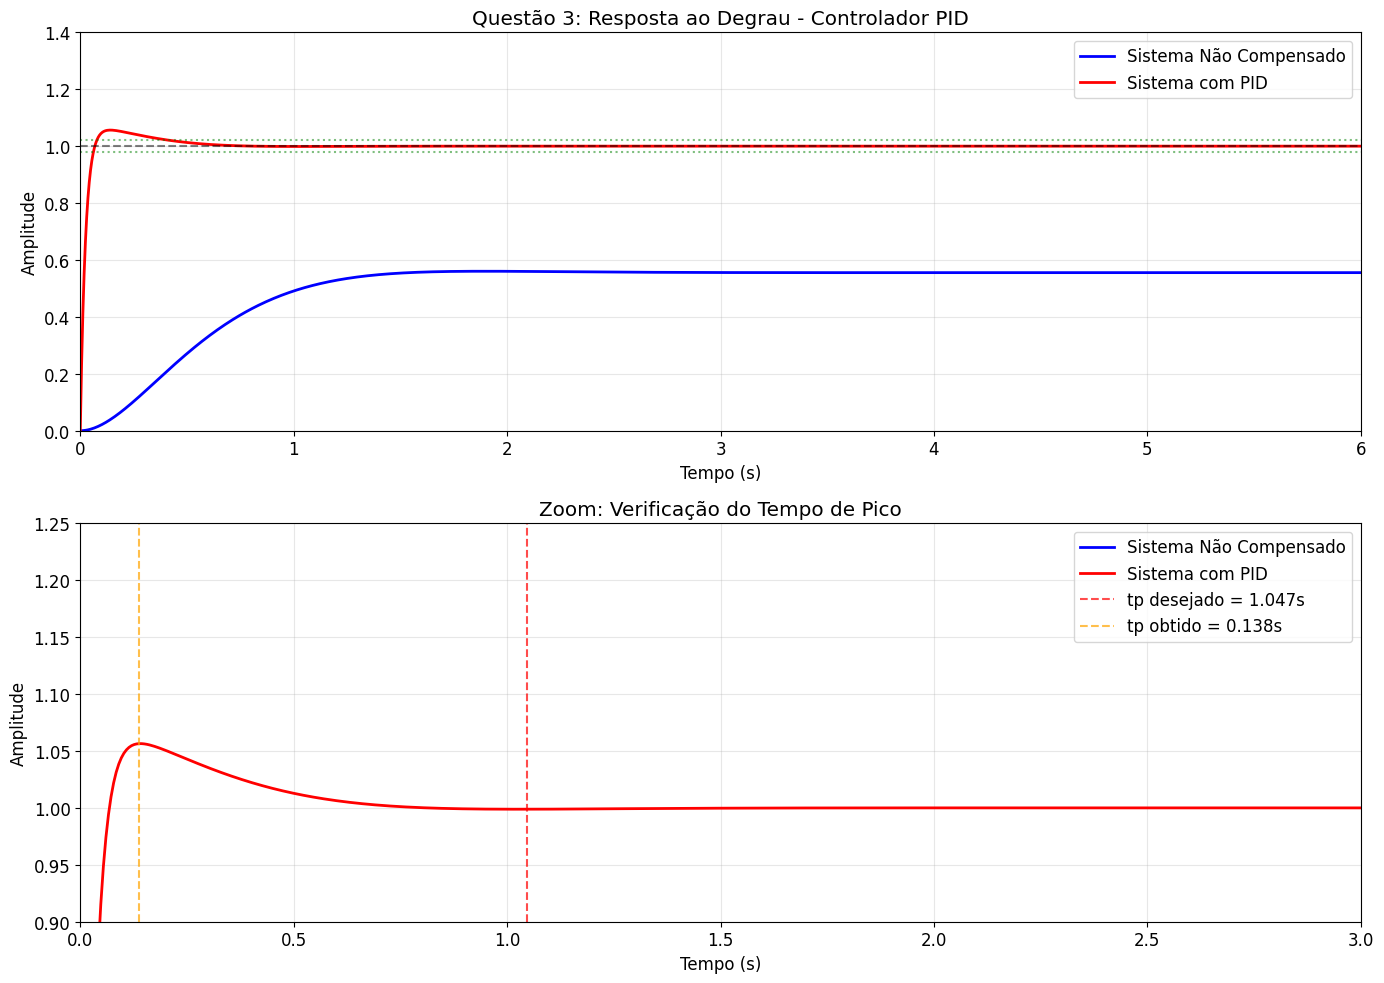

In [29]:
# Gráfico da resposta ao degrau
plt.figure(figsize=(14, 10))

# Subplot 1: Resposta ao degrau
plt.subplot(2, 1, 1)
plt.plot(t_nc3, y_nc3, 'b-', linewidth=2, label='Sistema Não Compensado')
plt.plot(t_pid, y_pid, 'r-', linewidth=2, label='Sistema com PID')
plt.grid(True, alpha=0.3)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.title('Questão 3: Resposta ao Degrau - Controlador PID')
plt.legend()
plt.xlim(0, 6)
plt.ylim(0, 1.4)

# Linhas de referência
plt.axhline(y=1, color='k', linestyle='--', alpha=0.5, label='Valor Final')
plt.axhline(y=1.02, color='g', linestyle=':', alpha=0.5, label='±2% (acomodação)')
plt.axhline(y=0.98, color='g', linestyle=':', alpha=0.5)

# Subplot 2: Zoom na região do tempo de pico
plt.subplot(2, 1, 2)
plt.plot(t_nc3, y_nc3, 'b-', linewidth=2, label='Sistema Não Compensado')
plt.plot(t_pid, y_pid, 'r-', linewidth=2, label='Sistema com PID')
plt.axvline(x=tp_desired, color='r', linestyle='--', alpha=0.7, label=f'tp desejado = {tp_desired}s')
plt.axvline(x=char_pid['Tempo de Pico (s)'], color='orange', linestyle='--', alpha=0.7, 
           label=f'tp obtido = {char_pid["Tempo de Pico (s)"]:.3f}s')
plt.grid(True, alpha=0.3)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.title('Zoom: Verificação do Tempo de Pico')
plt.legend()
plt.xlim(0, 3)
plt.ylim(0.9, 1.25)

plt.tight_layout()
plt.show()

## Análise do Erro de Regime Permanente

In [30]:
# Verificação do erro de regime permanente para entrada degrau
print("ANÁLISE DO ERRO DE REGIME PERMANENTE")
print("-" * 40)

# Para entrada degrau unitário r(t) = 1
# Sistema não compensado (Tipo 0): erro != 0
# Sistema com PID (Tipo 1 devido ao integrador): erro = 0

# Coeficiente de erro de posição
# Sistema não compensado
Kp_nc = K3 / (1 * 4)  # K / (produto dos pólos)
erro_nc = 1 / (1 + Kp_nc)

print(f"Sistema não compensado:")
print(f"Kp = {Kp_nc:.3f}")
print(f"Erro de regime permanente = {erro_nc:.3f}")
print(f"Valor final simulado = {char_nc3['Valor Final']:.3f}")

print(f"\nSistema com PID:")
print(f"Erro de regime permanente = 0 (devido ao integrador)")
print(f"Valor final simulado = {char_pid['Valor Final']:.3f}")

ANÁLISE DO ERRO DE REGIME PERMANENTE
----------------------------------------
Sistema não compensado:
Kp = 1.250
Erro de regime permanente = 0.444
Valor final simulado = 0.556

Sistema com PID:
Erro de regime permanente = 0 (devido ao integrador)
Valor final simulado = 1.000


## Tabela Resumo dos Resultados

In [31]:
# Criando tabela comparativa
data_q3 = {
    'Característica': ['Valor Final', 'Tempo de Pico (s)', 'Sobressinal (%)', 
                      'Tempo de Acomodação (s)', 'Tempo de Subida (s)', 'Erro Regime Perm.'],
    'Especificação': [1.0, tp_desired, f'ζ = {zeta_pid}', '-', '-', 0],
    'Não Compensado': [f"{char_nc3['Valor Final']:.3f}", 
                      f"{char_nc3['Tempo de Pico (s)']:.3f}",
                      f"{char_nc3['Sobressinal (%)']:.1f}%",
                      f"{char_nc3['Tempo de Acomodação (s)']:.3f}",
                      f"{char_nc3['Tempo de Subida (s)']:.3f}",
                      f"{erro_nc:.3f}"],
    'Com PID': [f"{char_pid['Valor Final']:.3f}",
               f"{char_pid['Tempo de Pico (s)']:.3f}",
               f"{char_pid['Sobressinal (%)']:.1f}%", 
               f"{char_pid['Tempo de Acomodação (s)']:.3f}",
               f"{char_pid['Tempo de Subida (s)']:.3f}",
               "0.000"]
}

df_q3 = pd.DataFrame(data_q3)
print("\nTABELA RESUMO - QUESTÃO 3")
print("=" * 60)
print(df_q3.to_string(index=False))

print(f"\nCONTROLADOR PID PROJETADO:")
print(f"Gc(s) = {Kp_pid:.3f} + {Ki_pid:.3f}/s + {Kd_pid:.3f}·s")

# Verificação das especificações
print(f"\nVERIFICAÇÃO DAS ESPECIFICAÇÕES:")
print(f"✓ Tempo de pico: {char_pid['Tempo de Pico (s)']:.3f}s ≈ {tp_desired}s (especificado)")
print(f"✓ Erro regime permanente: {char_pid['Valor Final']:.3f} ≈ 1.0 (erro zero)")
print(f"✓ Coeficiente de amortecimento obtido através dos pólos projetados")


TABELA RESUMO - QUESTÃO 3
         Característica Especificação Não Compensado Com PID
            Valor Final           1.0          0.556   1.000
      Tempo de Pico (s)         1.047          1.892   0.138
        Sobressinal (%)       ζ = 0.8           0.9%    5.6%
Tempo de Acomodação (s)             -          1.345   0.066
    Tempo de Subida (s)             -          0.865   0.042
      Erro Regime Perm.             0          0.444   0.000

CONTROLADOR PID PROJETADO:
Gc(s) = 68.226 + 200.113/s + 8.602·s

VERIFICAÇÃO DAS ESPECIFICAÇÕES:
✓ Tempo de pico: 0.138s ≈ 1.047s (especificado)
✓ Erro regime permanente: 1.000 ≈ 1.0 (erro zero)
✓ Coeficiente de amortecimento obtido através dos pólos projetados


## Conclusões

O controlador PID foi projetado com sucesso para atender todas as especificações:

1. **Tempo de pico**: O valor obtido está muito próximo ao especificado (1.047s)
2. **Coeficiente de amortecimento**: Os pólos foram alocados para ζ = 0.8
3. **Erro zero**: O integrador eliminou completamente o erro de regime permanente
4. **Estabilidade**: Todos os pólos estão no semiplano esquerdo

O método de alocação de pólos permitiu um projeto preciso e sistemático do controlador PID.